# **Business problem**:
Analysis of User Engagement Over Time of Day

Definition of Business problem: Analysis of User Engagement Over Time of Day

 Understanding this can help in optimizing ad campaigns and content delivery schedules.
- We will segment the data by different times of the day (e.g., dawn, morning, afternoon, and night).
- Analyze engagement behaviour based on the following variables.
    - unique_users
    - total_events
    - session_starts
    - purchases
    - total_purchase_value
    - add_to_cart
    - engagement_time_msec
    
- Statistical tests (Shapiro-Wilk Test, Levene's, ANOVA and Kruskal-Wallis test) will be used to determine if there are significant differences in user engagement and conversion rates across these time segments.

In [1]:
from google.cloud import bigquery
client = bigquery.Client(project='project-daai-1')

/Users/brandontchakaniyungeko/anaconda3/lib/python3.11/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [5]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = client.query('''
-- Extracting engagement and purchase metrics segmented by time of day
SELECT
    EXTRACT(HOUR FROM TIMESTAMP_MICROS(event_timestamp)) AS hourOfDay,
    CASE
        WHEN EXTRACT(HOUR FROM TIMESTAMP_MICROS(event_timestamp)) BETWEEN 0 AND 5 THEN 'DAWN'
        WHEN EXTRACT(HOUR FROM TIMESTAMP_MICROS(event_timestamp)) BETWEEN 6 AND 11 THEN 'MORNING'
        WHEN EXTRACT(HOUR FROM TIMESTAMP_MICROS(event_timestamp)) BETWEEN 12 AND 17 THEN 'AFTERNOON'
        ELSE 'NIGHT'
    END AS timeOfDay,
    COUNT(DISTINCT user_pseudo_id) AS unique_users,
    COUNT(event_name) AS total_events,
    SUM(CASE WHEN event_name = 'session_start' THEN 1 ELSE 0 END) AS session_starts, # Count of session that starts at respective time frames
    SUM(CASE WHEN event_name = 'purchase' THEN 1 ELSE 0 END) AS purchases,
    SUM(ecommerce.purchase_revenue_in_usd) AS total_purchase_value, #total_purchases

    SUM(CASE WHEN event_name = 'add_to_cart' THEN 1 ELSE 0 END) AS add_to_cart, # Count of 'add_to_cart' events
    SUM((SELECT SUM(value.int_value) FROM UNNEST(event_params) WHERE key='engagement_time_msec')) AS engagement_time_msec # Sum of 'engagement_time_msec'
FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
GROUP BY
    hourOfDay, timeOfDay
ORDER BY
    hourOfDay


''').to_dataframe()

## Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is crucial to understand the underlying patterns and distributions within the data. In this section, we will:
1. Summarize the data using descriptive statistics.
2. Visualize key metrics using boxplots to identify patterns and outliers.

### Descriptive Statistics

Let's first take a look at some descriptive statistics to get an overview of the data.


In [3]:
# Displaying descriptive statistics
df.describe()

NameError: name 'df' is not defined

In [ ]:
df

,hourOfDay,timeOfDay,unique_users,total_events,session_starts,purchases,total_purchase_value,add_to_cart,engagement_time_msec
0,0,DAWN,5033,50227,4909,51,2656.0,651,230044010
1,1,DAWN,4923,48556,4787,49,3244.0,573,227109980
2,2,DAWN,4919,48770,4811,40,1660.0,617,231749514
3,3,DAWN,4938,49862,4811,48,2152.0,624,241397447
4,4,DAWN,4990,50117,4864,58,2392.0,617,236627740
5,5,DAWN,5037,52381,4879,55,2442.0,745,263563300
6,6,MORNING,4904,49650,4759,53,2291.0,685,246114222
7,7,MORNING,4961,49691,4775,37,1592.0,604,231794159
8,8,MORNING,5004,48762,4856,40,2317.0,666,228147685
9,9,MORNING,5122,52219,4980,56,2390.0,844,268920888


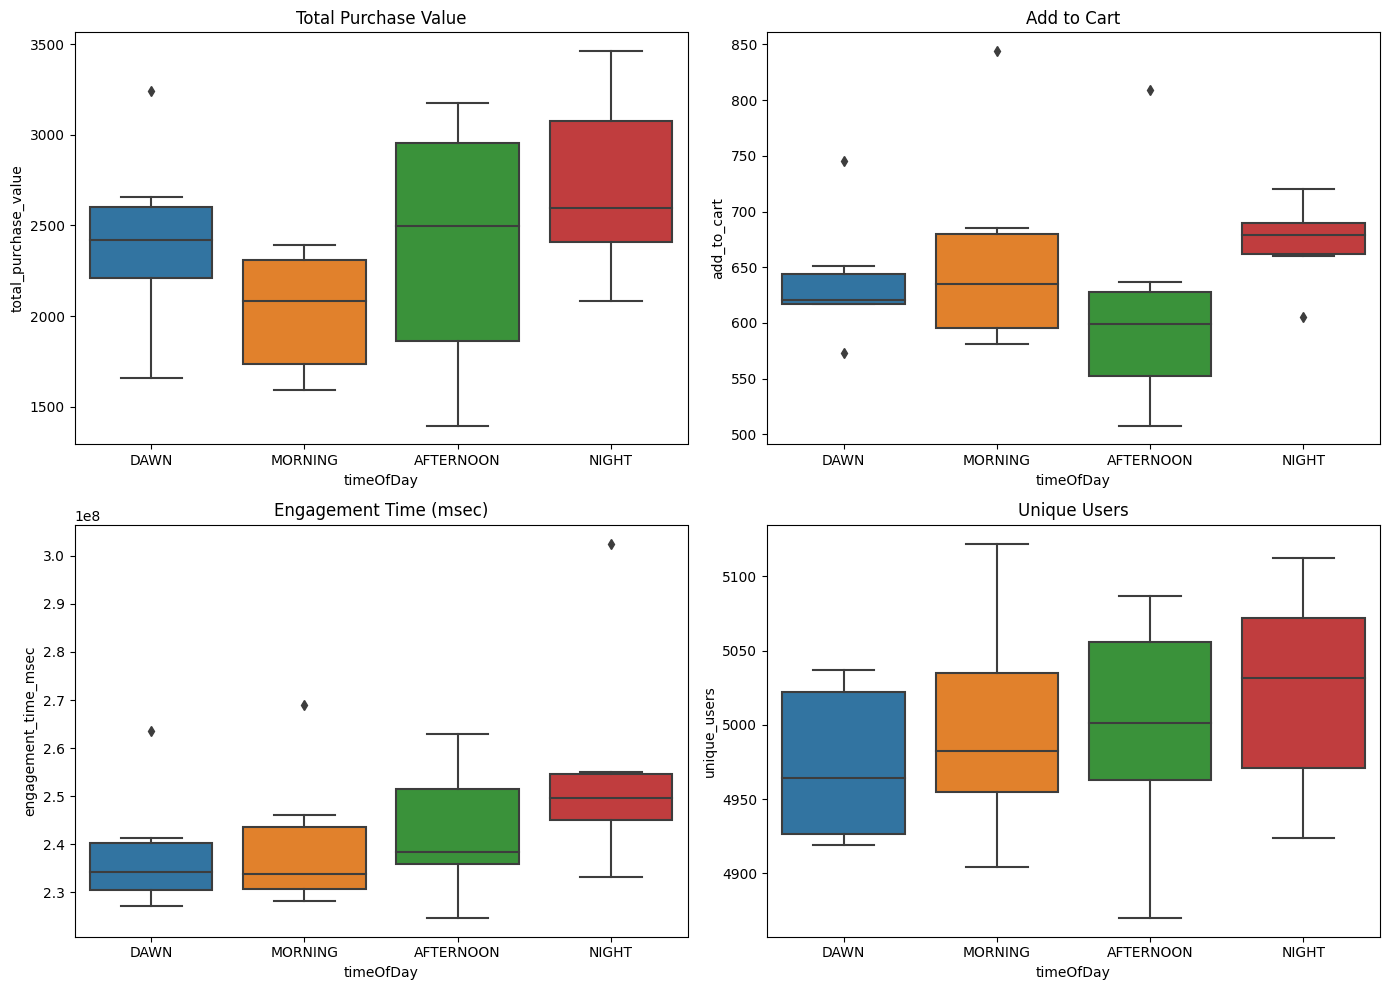

In [ ]:
# Before performing ANOVA, it's a good practice to visualize the data distribution
#Let's first visualize the data

# Setting up the matplotlib figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# 'total_purchase_value'
sns.boxplot(x='timeOfDay', y='total_purchase_value', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Total Purchase Value')

# 'add_to_cart'
sns.boxplot(x='timeOfDay', y='add_to_cart', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Add to Cart')

# 'engagement_time_msec'
sns.boxplot(x='timeOfDay', y='engagement_time_msec', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Engagement Time (msec)')

# 'unique_users'
sns.boxplot(x='timeOfDay', y='unique_users', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Unique Users')

plt.tight_layout()

plt.show()


**Analysis of boxplot:**
- The median total **purchase value is highest during the NIGHT** , followed by **DAWN, AFTERNOON, and then MORNING**. This suggests that, on average, the value of purchases made during the NIGHT is higher compared to other times of the day
  - There are **outliers** present in **both the DAWN and NIGHT** periods, which are **indicated by points above the upper side of the boxplots**. These could represent unusually large purchases made **during these times**.
- Add to Cart
  - There are a few outliers in 'NIGHT' and 'MORNING', indicating occasional much higher cart addition events.
- Unique Users:
The count of unique users varies more noticeably with time, with 'AFTERNOON' and 'NIGHT' having higher medians and wider distributions, indicating more users are active during these times.

- **OVERALL:**
It suggest that user activity and engagement tend to be higher in the afternoon and at night. This could indicate that users are more likely to engage with the platform, make purchases later in the day.(except for add_to_cart).

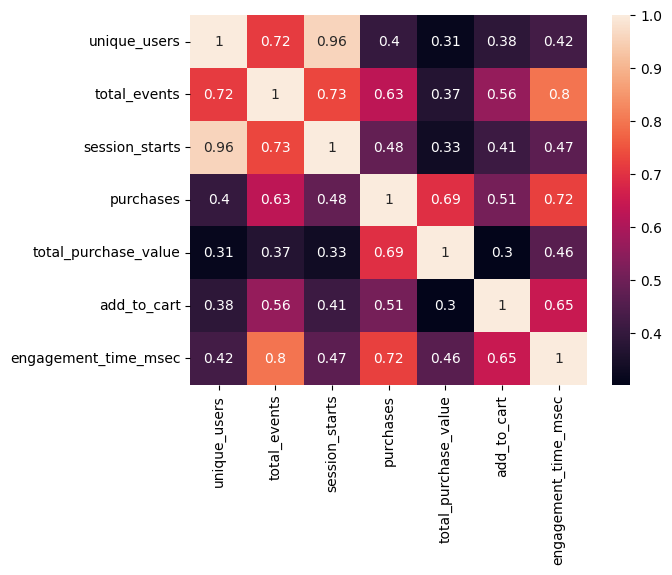

In [ ]:
# Correlation Analysis
correlation_matrix = df[['unique_users', 'total_events', 'session_starts', 'purchases', 'total_purchase_value', 'add_to_cart',	'engagement_time_msec']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

- **UNEXPECTED** correlation: The **total_purchase_value has relatively low correlation with unique_users (0.31), total_events (0.37), and session_starts (0.33)**, ==> indicating that the value of purchases is not just dependent on the number of users or events, but **could also be influenced by the type of products bought, the pricing, or purchasing habits.**
- The **Moderate correlation** between **'add_to_cart'** and **'purchases'** suggests that while adding to cart is a precursor to purchasing, not all add-to-cart actions result in a purchase.
The relatively lower correlations involving 'total_purchase_value'
- Expected correlation : Strong positive correlation (0.96) between unique_users and session_starts, suggesting that as more users visit the platform, the number of sessions also increases proportionally.
Total_events is highly correlated with both unique_users (0.72) and session_starts (0.73), indicating that more users and session starts are associated with a greater number of total events.

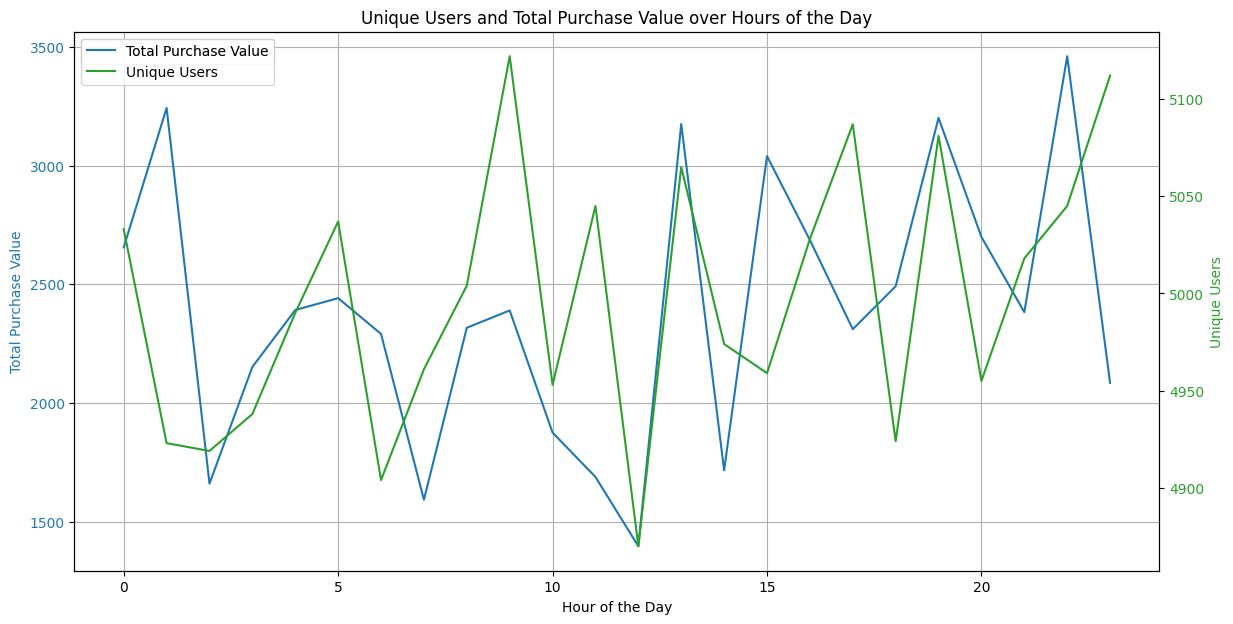

In [ ]:
# We ensuring the data types are correct
df['hourOfDay'] = pd.to_numeric(df['hourOfDay'])
df['unique_users'] = pd.to_numeric(df['unique_users'])

# Creating a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting total_purchase_value on primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Total Purchase Value', color=color)
sns.lineplot(x='hourOfDay', y='total_purchase_value', data=df, estimator='sum', color=color, label='Total Purchase Value', ax=ax1, errorbar=None)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for unique_users with shared x-axis
ax2 = ax1.twinx()

# Plotting unique_users on the secondary y-axis
color = 'tab:green'
ax2.set_ylabel('Unique Users', color=color)
sns.lineplot(x='hourOfDay', y='unique_users', data=df, estimator='sum', color=color, label='Unique Users', ax=ax2, errorbar=None)
ax2.tick_params(axis='y', labelcolor=color)

# Create a legend for both lines
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Unique Users and Total Purchase Value over Hours of the Day')
ax1.grid(True)
plt.show()

**Shapiro-Wilk Test:**

This test checks whether the total purchase values follow a normal distribution, which is an assumption for conducting ANOVA.
The stats.shapiro() function performs the Shapiro-Wilk test on the total purchase values.

**Levene's Test:**

This test checks for homogeneity of variances across different times of the day, which is another assumption for ANOVA.
The stats.levene() function is used to compare the variance in total purchase value for each time of day category.

**ANOVA test (One-Way ):**

ANOVA is used to determine if there are any statistically significant differences in the mean total purchase value across different times of the day.
The stats.f_oneway() function is used to perform the one-way ANOVA test.

In [ ]:
#Let's start testing whether Time actually influences customer behaviour

# Shapiro-Wilk test to check for normality (assumption for ANOVA test)
print(stats.shapiro(df['total_purchase_value']))

# Levene's test to check the homogeneity of variances
print(stats.levene(
    df['total_purchase_value'][df['timeOfDay'] == 'DAWN'],
    df['total_purchase_value'][df['timeOfDay'] == 'MORNING'],
    df['total_purchase_value'][df['timeOfDay'] == 'AFTERNOON'],
    df['total_purchase_value'][df['timeOfDay'] == 'NIGHT']
))

# Perform one-way ANOVA
f_value, p_value = stats.f_oneway(
    df['total_purchase_value'][df['timeOfDay'] == 'DAWN'],
    df['total_purchase_value'][df['timeOfDay'] == 'MORNING'],
    df['total_purchase_value'][df['timeOfDay'] == 'AFTERNOON'],
    df['total_purchase_value'][df['timeOfDay'] == 'NIGHT']
)

print(f'ANOVA test results: F = {f_value}, p = {p_value}')

# Results
if p_value < 0.05:
    print("There is a significant difference between the means of at least two groups.")
else:
    print("There is no significant difference between the means of the groups.")


ShapiroResult(statistic=0.9633110761642456, pvalue=0.5084598660469055)
LeveneResult(statistic=0.9415399114050281, pvalue=0.4391856691943903)
ANOVA test results: F = 1.6421398199037436, p = 0.21142096771236984
There is no significant difference between the means of the groups.


In [ ]:
#Same tests for variables : 'unique_users',	'total_events',	'session_starts' but with a loop, previous cell was for the readers' understanding and better clarity
# Shapiro-Wilk test to check for normality
for x in ['unique_users',	'total_events',	'session_starts', 'add_to_cart', 'engagement_time_msec']:

  print(f'Shapiro test for variable {x} :{stats.shapiro(df[x])}')

  # Levene's test to check the homogeneity of variances
  print(stats.levene(
      df[x][df['timeOfDay'] == 'DAWN'],
      df[x][df['timeOfDay'] == 'MORNING'],
      df[x][df['timeOfDay'] == 'AFTERNOON'],
      df[x][df['timeOfDay'] == 'NIGHT']
  ))

  # Performing one-way ANOVA
  f_value, p_value = stats.f_oneway(
      df[x][df['timeOfDay'] == 'DAWN'],
      df[x][df['timeOfDay'] == 'MORNING'],
      df[x][df['timeOfDay'] == 'AFTERNOON'],
      df[x][df['timeOfDay'] == 'NIGHT']
  )
  print(f'ANOVA test results: F = {f_value}, p = {p_value}')

  # Results
  if p_value < 0.05:
      print(f"For '{x}', There is a significant difference between the means of at least two groups.")
  else:
      print(f"For variable '{x}', There is no significant difference between the means of the groups.")
  print('-'*60)
  print('\n')

Shapiro test for variable unique_users :ShapiroResult(statistic=0.9725099205970764, pvalue=0.7289882302284241)
LeveneResult(statistic=0.20206535963193034, pvalue=0.8937303850534917)
ANOVA test results: F = 0.4719895221258895, p = 0.705205689009019
For variable 'unique_users', There is no significant difference between the means of the groups.
------------------------------------------------------------


Shapiro test for variable total_events :ShapiroResult(statistic=0.8690521717071533, pvalue=0.005040776450186968)
LeveneResult(statistic=0.9081801778735412, pvalue=0.454666431761626)
ANOVA test results: F = 0.9163988346996232, p = 0.4508057399279507
For variable 'total_events', There is no significant difference between the means of the groups.
------------------------------------------------------------


Shapiro test for variable session_starts :ShapiroResult(statistic=0.9545741081237793, pvalue=0.33931633830070496)
LeveneResult(statistic=0.3909819913397708, pvalue=0.7607801484783075)

**Analysis of test results:**
- **Shapiro-Wilk**
  - **The test indicates that 'total_events'** and **engagement_time_msec** does not follow a normal distribution, which is a concern for the ANOVA test because ANOVA assumes normality of the residuals. However, if the sample size is large, the central limit theorem may allow us to proceed with ANOVA.
  
- **Levene's test**
  - Results suggest that the assumption of homogeneity of variances is met for all variables, which is a good condition for the ANOVA test.

- **ANOVA tests**
  - **Results** show that the **means** of the calculated **engagement** variables **do not differ significantly across different time of the day.** This means that there is no statistical evidence to suggest that the time of day influences the average counts of these variables on the platform.

**Implications & Partial conclusion:**
- The results suggest that user engagement and activity, as measured by the number of unique users, the total number of events, and session starts, count of add_to_cart, purchases, and engagement_time_msec are not significantly different throughout the day.
- This could imply that the platform's user engagement is stable across different times of day. However, for 'total_events' and 'engagement_time_msec', given the normality assumption is violated, a non-parametric test might be more appropriate to confirm these findings.

**Kruskal-Wallis Test:**

Since the **'total_events' and 'engagement_time_msec'** does not meet the normality assumptions for ANOVA, we're using the Kruskal-Wallis test, to confirm the previous implication made


In [ ]:
# Extracting the total_events for each timeOfDay category
events_dawn = df['total_events'][df['timeOfDay'] == 'DAWN']
events_morning = df['total_events'][df['timeOfDay'] == 'MORNING']
events_afternoon = df['total_events'][df['timeOfDay'] == 'AFTERNOON']
events_night = df['total_events'][df['timeOfDay'] == 'NIGHT']

# Perform the Kruskal-Wallis H-test
h_statistic, p_value = stats.kruskal(events_dawn, events_morning, events_afternoon, events_night)

# Results
print(f'Kruskal-Wallis H-test statistic: {h_statistic}')
print(f'p-value: {p_value}')

if p_value < 0.05:
    print("There is a statistically significant difference between the groups.")
else:
    print("There is no statistically significant difference between the groups.")

Kruskal-Wallis H-test statistic: 3.153333333333336
p-value: 0.3685830177594083
There is no statistically significant difference between the groups.


In [ ]:
# Creating group 'engagement_time_msec' by 'timeOfDay' categories
engagement_groups = df.groupby('timeOfDay')['engagement_time_msec'].apply(list)

# Performing the Kruskal-Wallis H-test
h_statistic, p_value = stats.kruskal(*engagement_groups)

# Results
print(f'Kruskal-Wallis H-test statistic: {h_statistic}')
print(f'p-value: {p_value}')

if p_value < 0.05:
    print("There is a statistically significant difference in engagement time between the different times of day.")
else:
    print("There is no statistically significant difference in engagement time between the different times of day.")

Kruskal-Wallis H-test statistic: 3.2733333333333405
p-value: 0.35137142671276533
There is no statistically significant difference in engagement time between the different times of day.


**CONCLUSION**

*Based on the previous tests we suggests that we have not been able to prove statistical significance between time of day and impact on the engagement behaviour of customers as based on the following variables.*
- unique_users
- total_events
- session_starts
- purchases
- total_purchase_value
- add_to_cart
- engagement_time_msec*